# Apply Perturbations to Tumor-Specific Genes in SCC

**helical-ai:** Utilize the workflow to target previously-reported tumor-specific genes in squamous
cell carcinoma (SCC) populations which contribute to pathology. Simulate
perturbations and process the resulting data using the GeneFormer_V2_Cancer model
to embed the perturbation effects into a biologically informed latent space.

**Titouan:** This step took me a bit more time as the task seemed somewhat open-ended. I ultimately chose to import the count data from the SCC Dataset (PMC7391009), apply my in-silico perturbation method to tumor-related genes, and embed the perturbed and unperturbed results for further analysis in step 3. I also faced a few issues stemming from working on my laptop, mainly issues with memory and the slow embedding process.

## 1) Imports & seed

In [1]:
import numpy as np
import gzip
import requests
import anndata as ad
import pandas as pd
import random
import scanpy as sc
from anndata import AnnData

seed = 42
np.random.seed(seed)

## 2) Downloading data & processing data

I took the count data from the experiments on SCC from the PMC7391009 paper.

### 2.1) Downloading and extracting

In [2]:
filename = "SCCcounts.txt.gz"
url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE144nnn/GSE144236/suppl/GSE144236%5FcSCC%5Fcounts%2Etxt%2Egz"

print(f"Downloading {filename}...")
response = requests.get(url)

if response.status_code == 200:
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"Downloaded: {filename}")
else:
    print(f"Failed to download {filename}. HTTP status code: {response.status_code}")

# Uncompress
filename_uncompressed = filename.split(".")[0] + ".txt"
with gzip.open(filename, 'rt') as infile:
    with open(filename_uncompressed, 'w') as outfile:
        for line in infile:
            outfile.write(line)
    print(f"Uncompressed: {filename_uncompressed}")

Downloaded: SCCcounts.txt.gz
Uncompressed: SCCcounts.txt


### 2.2) .txt to AnnData

Since we downloaded raw count data (i.e., the number of reads for each gene in each sample), we now need to format this data into an AnnData object. I built a simple parser that reads a specified number of samples (columns) in a memory-efficient manner. It also selects random columns without repetition to avoid always using the first N samples.

chunk_size = 5000
N = 6400 # I don't have enough memory to load every sample
processed_chunks = []
gene_names = []
obs_names = []
patient = []
tissue = []
total = 0

with open(filename_uncompressed, "r") as file:
    # Read the header (column/sample names)
    header = file.readline().strip().split("\t")[:N]
    patient = list(map(int, file.readline().strip().split("\t")[1:N + 1]))
    tissue = list(map(int, file.readline().strip().split("\t")[1:N + 1]))
    obs_names = header

    while True:
        # Read the next chunk of rows
        chunk = []
        chunk_gene_names = []
        for _ in range(chunk_size):
            line = file.readline()
            if not line:
                break
            # Split the line into gene name and expression values
            row = line.strip().split("\t")
            chunk_gene_names.append(row[0])  # First value is the gene name
            chunk.append(row[1:N + 1])  # Remaining values are expression data
            
        # If no more data, break the loop
        if not chunk:
            break

        chunk_array = np.array(chunk, dtype=int)

        # Append chunk
        processed_chunks.append(chunk_array)
        gene_names.extend(chunk_gene_names)

        total += len(chunk)
        if total % 5000 == 0: print(f"Processed {total}/32740 rows")
print("finished")

chunk_size = 5000
N = 6400 # I don't have enough memory to load every sample
processed_chunks = []
gene_names = []
obs_names = []
patient = []
tissue = []
total = 0

with open(filename_uncompressed, "r") as file:
    # Read the header (column/sample names)
    header = file.readline().strip().split("\t")[:N]
    patient = list(map(int, file.readline().strip().split("\t")[1:N + 1]))
    tissue = list(map(int, file.readline().strip().split("\t")[1:N + 1]))
    obs_names = header

    # Get the total number of data lines (after the header, patient, and tissue rows)
    file.seek(0)
    total_lines = sum(1 for _ in file) - 3  # Subtract header, patient, tissue

    # Create a list of line indices, shuffle them randomly
    line_indices = list(range(total_lines))
    random.shuffle(line_indices)

    processed_chunks = []
    gene_names = []
    total = 0

    # Read in chunks according to shuffled indices
    for i in range(0, total_lines, chunk_size):
        chunk_indices = line_indices[i:i + chunk_size]
        chunk_indices.sort()  # Sort to minimize disk seek time

        chunk = []
        chunk_gene_names = []

        with open(filename_uncompressed, "r") as file:
            # Skip header, patient, and tissue rows
            for _ in range(3):
                file.readline()

            for idx, line in enumerate(file):
                if idx in chunk_indices:
                    row = line.strip().split("\t")
                    chunk_gene_names.append(row[0])  # First value is the gene name
                    chunk.append(row[1:N + 1])  # Remaining values are expression data

        if not chunk:
            break

        chunk_array = np.array(chunk, dtype=int)

        # Append chunk
        processed_chunks.append(chunk_array)
        gene_names.extend(chunk_gene_names)

        total += len(chunk)
        if total % 5000 == 0:
            print(f"Processed {total}/{total_lines} rows")
print("finished")

In [3]:
chunk_size = 5000
N = 5000 # I don't have enough memory to load every sample
processed_chunks = []
gene_names = []
obs_names = []
patient = []
tissue = []
total = 0
total_lines = sum(1 for _ in open(filename_uncompressed, 'rb'))

with open(filename_uncompressed, "r") as file:
    # Read the header (column/sample names)
    header = file.readline().strip().split("\t")
    n_samples = len(header)
    samples_idx = np.random.choice(np.arange(0, n_samples), size=N, replace=False)
    
    patient = file.readline().strip().split("\t")
    patient = [patient[i + 1] for i in samples_idx]
    patient = list(map(int, patient))
    
    tissue = file.readline().strip().split("\t")
    tissue = [tissue[i + 1] for i in samples_idx]
    tissue = list(map(int, tissue))
    
    obs_names = [header[i] for i in samples_idx]

    processed_chunks = []
    gene_names = []
    total = 0

    while True:
        # Read the next chunk of rows
        chunk = []
        chunk_gene_names = []
        for _ in range(chunk_size):
            line = file.readline()
            if not line:
                break
            # Split the line into gene name and expression values
            row = line.strip().split("\t")
            chunk_gene_names.append(row[0])  # First value is the gene name
            chunk.append([row[i + 1] for i in samples_idx])  # Remaining values are expression data
            
        # If no more data, break the loop
        if not chunk:
            break

        chunk_array = np.array(chunk, dtype=int)

        # Append chunk
        processed_chunks.append(chunk_array)
        gene_names.extend(chunk_gene_names)

        total += len(chunk)
        if total % 5000 == 0:
            print(f"Processed {total}/{total_lines} rows")

print(f"Processed {total}/{total_lines} rows -> finished!")

Processed 5000/32741 rows
Processed 10000/32741 rows
Processed 15000/32741 rows
Processed 20000/32741 rows
Processed 25000/32741 rows
Processed 30000/32741 rows
Processed 32738/32741 rows -> finished!


In [4]:
# Combine all processed chunks into a single NumPy array
final_data = np.vstack(processed_chunks)
final_data = final_data.T

# Create an AnnData object
adata = AnnData(X=final_data)

gene_names = [gene.replace('"', '') for gene in gene_names]
obs_names = [obs.replace('"', '') for obs in obs_names]
adata.var.index = gene_names
adata.var["gene_names"] = gene_names
adata.obs["samples"] = obs_names
adata.obs["patient"] = patient
adata.obs["tissue"] = tissue
adata

AnnData object with n_obs × n_vars = 5000 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

### 2.3) Looking at our AnnData object

In [5]:
adata.obs['samples']

0        P5_Tumor_AAAGATGTCCTCCTAG
1       P2_Normal_TGGGCGTTCCGTCATC
2       P10_Tumor_CTTGGCTTCTCTAAGG
3        P4_Tumor_CGAGAAGCATCCTAGA
4       P9_Normal_ACTATCTTCGATCCCT
                   ...            
4995    P7_Normal_CAAGAAAGTCGCATAT
4996    P2_Normal_AATCCAGCATCACGTA
4997    P2_Normal_GCGCCAACATCATCCC
4998     P7_Tumor_CTCGGGACAACGATCT
4999    P8_Normal_GTTAAGCAGACATAAC
Name: samples, Length: 5000, dtype: object

In [6]:
adata.obs['tissue']

0       1
1       0
2       1
3       1
4       0
       ..
4995    0
4996    0
4997    0
4998    1
4999    0
Name: tissue, Length: 5000, dtype: int64

## 3) Simulating perturbations

### 3.1) Importing step 1

In [7]:
import nbimporter # I don't recommend using this module, this is used only to keep everything in notebooks
from step1_insilico_perturbation import perturb_genes_counts

### 3.2) Identifying genes of interest

According to the study PMC7391009 the genes of interest are:
- Keratin genes (specific to TSK cells): Keratinocytes within tumors express specific keratins, which may be unique to tumor states.
- CD8 and CD4 T cell-associated genes: Genes related to immune cell infiltration, such as T regulatory (Treg) cells and CD8 T cells, were observed in the tumor stroma, indicating potential immunosuppressive features.
- Ligand-receptor network genes: These include genes related to cell-cell communication that were mapped to specific tumor and stromal cell types, although specific gene names were not provided in the summary.

keratin_genes = [gene for gene in adata.var["gene_names"] if "KRT" in gene]
print(keratin_genes[:10])

immune_cell_genes = [gene for gene in adata.var["gene_names"] if "CD8" in gene or "CD4" in gene or "FOXP3" in gene]
print(immune_cell_genes[:10])

ligand_receptor_genes = [gene for gene in adata.var["gene_names"] if "EGFR" in gene or "CXCR" in gene or "CCR" in gene]
print(ligand_receptor_genes[:10])

I couldn't find the tumor specific genes in the paper so I decided to just extract them myself from the raw counts data using differential expression analysis

In [8]:
adata_pert = adata.copy() # Making a copy because we still need the raw counts for GeneFormer

In [9]:
adata_pert.var_names

Index(['RP11-34P13.7', 'AL627309.1', 'AP006222.2', 'RP4-669L17.10',
       'RP11-206L10.3', 'RP11-206L10.2', 'RP11-206L10.9', 'FAM87B',
       'LINC00115', 'FAM41C',
       ...
       'BX072566.1', 'KIR2DL2', 'KIR3DL2.1', 'AL590523.1', 'CT476828.1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

In [10]:
# Filter out genes with low counts across spots
sc.pp.filter_genes(adata_pert, min_cells=3)

# Normalize the data (Scanpy will handle size factor normalization)
sc.pp.normalize_total(adata_pert, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata_pert)
adata_pert

AnnData object with n_obs × n_vars = 5000 × 20141
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names', 'n_cells'
    uns: 'log1p'

In [11]:
adata_pert.obs['tissue'] = pd.Categorical(adata_pert.obs['tissue'], categories=[0, 1])

# Map the integers to meaningful labels (e.g., 'healthy' and 'tumor')
category_mapping = {0: 'healthy', 1: 'tumor'}
adata_pert.obs['tissue'] = adata_pert.obs['tissue'].map(category_mapping)

# Convert back to categorical with labeled categories
adata_pert.obs['tissue'] = pd.Categorical(adata_pert.obs['tissue'], categories=['healthy', 'tumor'])
adata_pert

AnnData object with n_obs × n_vars = 5000 × 20141
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names', 'n_cells'
    uns: 'log1p'

In [12]:
sc.tl.rank_genes_groups(adata_pert, groupby='tissue', method='t-test')

In [13]:
# Perform differential expression analysis using t-test
sc.tl.rank_genes_groups(adata_pert, groupby='tissue', method='t-test')

# Extract the results for the top N genes for each group
top_genes = adata_pert.uns['rank_genes_groups']['names']  # Get the gene names for all groups

N = 1000 # top 1000 genes (chosen arbitrarily)

# Extract the top N genes from each group
top_genes_N = {group: top_genes[group][:N] for group in top_genes.dtype.names}

# Extract the log fold change for each gene
log_fold_changes = adata_pert.uns['rank_genes_groups']['logfoldchanges']

# Extract the p-values for the genes
p_values = adata_pert.uns['rank_genes_groups']['pvals']

# Determine whether each gene is over- or under-expressed based on log-fold change
# log-fold change = log2(expressionA/expressionB) so log2 > 0: over-expressed and log2 < 0: underexpressed
# this ends up being useless because they end up being all over-expressed due to how scipy selects the genes
expression_status = {group: ['over-expressed' if fc > 0 else 'under-expressed' for fc in log_fold_changes[group][:N]] 
                     for group in log_fold_changes.dtype.names}

# Combine the gene names, log fold change, p-values, and expression status into a dataframe
top_genes_info = []
for group in top_genes_N:
    for gene, fc, p_val, status in zip(top_genes_N[group], log_fold_changes[group][:N], p_values[group][:N], expression_status[group]):
        top_genes_info.append({
            'Group': group,
            'Gene': gene,
            'Log Fold Change': fc,
            'P-Value': p_val,
            'Expression Status': status
        })

top_genes_df = pd.DataFrame(top_genes_info)

# Show the result
print(top_genes_df)

        Group    Gene  Log Fold Change        P-Value Expression Status
0     healthy    SIK1         2.737688  2.137507e-303    over-expressed
1     healthy    EGR1         2.257723  1.111294e-294    over-expressed
2     healthy    FOSB         1.929482  1.484942e-278    over-expressed
3     healthy    KRT1         3.292260  3.931046e-249    over-expressed
4     healthy   KRT10         2.874529  1.941393e-244    over-expressed
...       ...     ...              ...            ...               ...
1995    tumor   EIF4E         0.478885   3.990513e-18    over-expressed
1996    tumor   KRT6C         0.768156   4.014737e-18    over-expressed
1997    tumor   MPEG1         1.204610   4.086948e-18    over-expressed
1998    tumor    GBP6         1.827913   4.326594e-18    over-expressed
1999    tumor  ATP5C1         0.336425   4.257063e-18    over-expressed

[2000 rows x 5 columns]


/opt/conda/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 20141 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


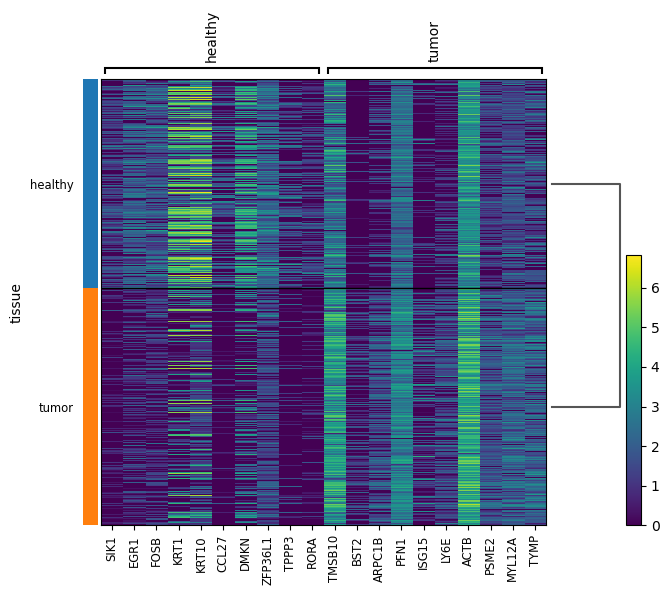

In [14]:
sc.pl.rank_genes_groups_heatmap(adata_pert, n_genes=10, groupby='tissue', show=True)

In [15]:
healthy_genes = top_genes_N.get('healthy', [])
print(healthy_genes[:100])
tumor_genes = top_genes_N.get('tumor', [])
print(tumor_genes[:100])

['SIK1' 'EGR1' 'FOSB' 'KRT1' 'KRT10' 'CCL27' 'DMKN' 'ZFP36L1' 'TPPP3'
 'RORA' 'ZFP36L2' 'TRIM29' 'NEAT1' 'KLF4' 'PKP1' 'RPS8' 'FOS' 'LMNA'
 'NR4A1' 'ZFP36' 'KLF5' 'NRARP' 'MYC' 'APOE' 'CD55' 'MT-ND3' 'RPL31'
 'RPLP1' 'JUNB' 'EMP1' 'DSP' 'DSC3' 'ATF3' 'LGALS7B' 'SLC38A2' 'LDLR'
 'IRF6' 'JUND' 'JUP' 'ZC3H12A' 'DSG1' 'LGALS7' 'FGFR3' 'RPL36A' 'ID1'
 'DAPL1' 'PERP' 'KLK11' 'CDHR1' 'GATM' 'TUBB2A' 'EPHA2' 'TNFRSF19'
 'KRTDAP' 'RPS18' 'LYPD3' 'SEPP1' 'MT1X' 'RND3' 'RPL37A' 'IER2' 'LY6D'
 'CAPNS2' 'HOPX' 'DUSP1' 'TOB1' 'EPHB6' 'GATA3' 'RPLP2' 'EXPH5' 'RPL37'
 'MIDN' 'TNS4' 'KRT2' 'LGALS3' 'CLEC2B' 'KCNK7' 'PER1' 'SDC1' 'SERTAD1'
 'DEGS1' 'H3F3B' 'RPL36' 'EZR' 'AQP3' 'APCDD1' 'PALMD' 'MIR24-2' 'GPC1'
 'SFN' 'DSC1' 'TMEM45A' 'CRIP2' 'TOB2' 'CYR61' 'DEFB1' 'CEBPA' 'EMP2'
 'SNHG8' 'GLTSCR2']
['TMSB10' 'BST2' 'ARPC1B' 'PFN1' 'ISG15' 'LY6E' 'ACTB' 'PSME2' 'MYL12A'
 'TYMP' 'CFL1' 'LAP3' 'PRELID1' 'ARPC2' 'CTSC' 'SERPINB1' 'CYBA' 'CAP1'
 'GBP1' 'CTSB' 'TPM3' 'MX1' 'SUB1' 'IFI6' 'COTL1' 'FTL' 'LGALS1'

In [16]:
del adata_pert # for memory

### 3.3) Splitting the data

In [17]:
adata_tumor = adata[adata.obs['tissue'] == 1].copy()
adata_tumor

AnnData object with n_obs × n_vars = 2662 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

In [18]:
adata_healthy = adata[adata.obs['tissue'] == 0].copy()
adata_healthy

AnnData object with n_obs × n_vars = 2338 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

In [19]:
del adata

### 3.4) Simulating knock-up of tumor-specific genes and knock-down of healthy genes in healthy cells

Let's see if we can 'create' tumor cells from healthy cells by only touching the genes we believe contribute to the pathology. We'll later see how this looks in the embeddings.

In [20]:
fold_change = 0.9

In [21]:
perturbed_healthy_adata = perturb_genes_counts(adata_healthy.copy(), "gene_names", tumor_genes, "knock-up", fold_change)
perturbed_healthy_adata = perturb_genes_counts(adata_healthy.copy(), "gene_names", healthy_genes, "knock-down", fold_change)
perturbed_healthy_adata.obs['tissue'] = 2 # Set a tag for latter (0: healthy, 1: tumor, 2: healthy_knock-up, 3: tumor_knock-down)
perturbed_healthy_adata.obs.index = perturbed_healthy_adata.obs.index + "_MODIFIED"
perturbed_healthy_adata

AnnData object with n_obs × n_vars = 2338 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

### 3.5) Simulating knock-down of tumor-specific genes in cancerous cells

See above

In [22]:
perturbed_tumor_adata = perturb_genes_counts(adata_tumor.copy(), "gene_names", healthy_genes, "knock-up", fold_change)
perturbed_tumor_adata = perturb_genes_counts(adata_tumor.copy(), "gene_names", tumor_genes, "knock-down", fold_change)
perturbed_tumor_adata.obs['tissue'] = 3 # Set a tag for latter (0: healthy, 1: tumor, 2: healthy_knock-up, 3: tumor_knock-down)
perturbed_tumor_adata.obs.index = perturbed_tumor_adata.obs.index + "_MODIFIED"
perturbed_tumor_adata

AnnData object with n_obs × n_vars = 2662 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

### 3.6) Putting it all back together

In [23]:
adata_combined = ad.concat([adata_tumor, adata_healthy, perturbed_healthy_adata, perturbed_tumor_adata], join='outer', merge='same') 
adata_combined

AnnData object with n_obs × n_vars = 10000 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

In [24]:
del adata_tumor
del adata_healthy
del perturbed_healthy_adata
del perturbed_tumor_adata

## 4) Checkpoint

In [25]:
def save_anndata(adata: AnnData, file_path: str):
    """
    Saves an AnnData object to a specified file path.
    
    Args:
        adata (AnnData): The AnnData object to save.
        file_path (str): Path to save the `.h5ad` file.
    """
    try:
        adata.write(file_path)
        print(f"AnnData object successfully saved to {file_path}")
    except Exception as e:
        print(f"Error saving AnnData object: {e}")

file_path = "checkpoint.h5ad"
save_anndata(adata_combined, file_path)

AnnData object successfully saved to checkpoint.h5ad


## 5) Embedding

### 5.1) Imports

In [26]:
from helical import Geneformer, GeneformerConfig
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_config = GeneformerConfig(batch_size=10, device=device)
geneformer = Geneformer(configurer=model_config)

2024-12-03 16:29:33.567341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 16:29:33.687508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 16:29:33.732474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 16:29:33.749415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 16:29:33.849323: I tensorflow/core/platform/cpu_feature_guar

### 5.2) Conversion I need to do to make everything work

In [27]:
import scipy.sparse as sp

# Convert adata.X to a sparse CSR matrix with dtype=float64
if not sp.issparse(adata_combined.X):  # Check if it's already sparse
    adata_combined.X = sp.csr_matrix(adata_combined.X, dtype=np.float64)

### 5.3) Processing data & Embedding

In [28]:
dataset = geneformer.process_data(adata_combined, gene_names="gene_names") # Maybe seperate MODIFIED from the rest
dataset

INFO:pyensembl.download_cache:Fetching /home/jovyan/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz from URL https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
INFO:datacache.download:Downloading https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz to /home/jovyan/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz
INFO:pyensembl.download_cache:Fetching /home/jovyan/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz from URL https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/ncrna/Homo_sapiens.GRCh38.ncrna.fa.gz
INFO:datacache.download:Downloading https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/ncrna/Homo_sapiens.GRCh38.ncrna.fa.gz to /home/jovyan/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz
INFO:pyensembl.download_cache:Fetching /home/jovyan/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.p

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'length'],
    num_rows: 10000
})

In [29]:
dataset = dataset.add_column("tissue", adata_combined.obs['tissue'].tolist())
dataset = dataset.add_column("patient", adata_combined.obs['patient'].tolist())
dataset

Dataset({
    features: ['input_ids', 'length', 'tissue', 'patient'],
    num_rows: 10000
})

In [30]:
N = 1000  # Number of rows to sample because I don't have enough time to embedded them all
sampled_dataset = dataset.shuffle(seed=seed).select(range(N))
embeddings = geneformer.get_embeddings(sampled_dataset)
embeddings

INFO:helical.models.geneformer.model:Inference started:


  0%|          | 0/100 [00:00<?, ?it/s]

<frozen importlib._bootstrap>:1047: ImportWarning: NotebookFinder.find_spec() not found; falling back to find_module()


array([[-0.00152033,  0.00857751,  0.06852891, ..., -0.01273486,
        -0.0053502 , -0.03958685],
       [-0.01209087,  0.00812419,  0.08059379, ..., -0.00642472,
         0.00311027, -0.04242285],
       [-0.03827563, -0.02448463,  0.06833865, ..., -0.04742155,
         0.03480127, -0.05131922],
       ...,
       [-0.01957471, -0.01962318,  0.06823943, ..., -0.03117719,
         0.00642839, -0.03632931],
       [-0.0324485 , -0.02102665,  0.04771277, ..., -0.01398094,
         0.02815565, -0.02868117],
       [-0.04091785, -0.01616941,  0.05389525, ..., -0.0321766 ,
         0.01301332, -0.03640614]], dtype=float32)

## 6) Saving embeddings to a file

In [31]:
np.save("embeddings.npy", embeddings)

In [32]:
tissue_df = pd.DataFrame(sampled_dataset['tissue'], columns=["tissue"])
tissue_df.to_csv("embedding_tissue_info.csv", index=True)
tissue_df

,tissue
0,3
1,3
2,1
3,3
4,0
...,...
995,3
996,3
997,1
998,2


In [33]:
patient_df = pd.DataFrame(sampled_dataset['patient'], columns=["patient"])
patient_df.to_csv("embedding_patient_info.csv", index=True)
patient_df

,patient
0,4
1,7
2,7
3,4
4,2
...,...
995,9
996,7
997,4
998,2
